<a href="https://colab.research.google.com/github/xmadmaxdx/ML/blob/main/fcc_cat_dog.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
try:
  # This command only in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D, BatchNormalization, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import layers, models


import os
import numpy as np
import matplotlib.pyplot as plt

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [2]:

# Get project files
!wget https://cdn.freecodecamp.org/project-data/cats-and-dogs/cats_and_dogs.zip

!unzip cats_and_dogs.zip

PATH = 'cats_and_dogs'

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')
test_dir = os.path.join(PATH, 'test')

# Get number of files in each directory. The train and validation directories
# each have the subdirecories "dogs" and "cats".
total_train = sum([len(files) for r, d, files in os.walk(train_dir)])
total_val = sum([len(files) for r, d, files in os.walk(validation_dir)])
total_test = len(os.listdir(test_dir))

# Variables for pre-processing and training.
batch_size = 128
epochs = 15
IMG_HEIGHT = 150
IMG_WIDTH = 150

Streaming output truncated to the last 5000 lines.
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.60.jpg  
  inflating: cats_and_dogs/train/dogs/dog.858.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.858.jpg  
  inflating: cats_and_dogs/train/dogs/dog.680.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.680.jpg  
  inflating: cats_and_dogs/train/dogs/dog.694.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.694.jpg  
  inflating: cats_and_dogs/train/dogs/dog.864.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.864.jpg  
  inflating: cats_and_dogs/train/dogs/dog.870.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.870.jpg  
  inflating: cats_and_dogs/train/dogs/dog.871.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.871.jpg  
  inflating: cats_and_dogs/train/dogs/dog.865.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.865.jpg  
  inflating: cats_and_dogs/train/dogs/dog.695.jpg  
  inflating: __MACOSX/cats_and

In [32]:
# Create ImageDataGenerators for rescaling
train_image_generator = ImageDataGenerator(rescale=1./255)
validation_image_generator = ImageDataGenerator(rescale=1./255)
test_image_generator = ImageDataGenerator(rescale=1./255)

# Train data generator
train_data_gen = train_image_generator.flow_from_directory(
    directory=train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=batch_size,
    color_mode='rgb',
    class_mode='binary',
    shuffle=False
)

# Validation data generator
val_data_gen = validation_image_generator.flow_from_directory(
    directory=validation_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=batch_size,
    color_mode='rgb',
    class_mode='binary',
    shuffle=False
)

# Test data generator
test_data_gen = test_image_generator.flow_from_directory(
    directory=PATH,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=1,
    color_mode='rgb',
    class_mode='binary',
    shuffle=False,
    classes=['test']
)


Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 50 images belonging to 1 classes.


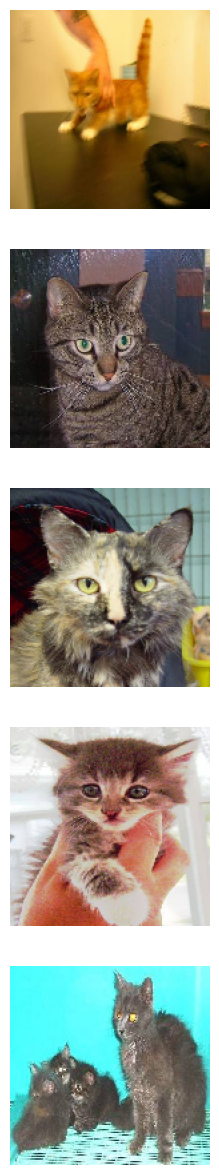

In [33]:
# 4
def plotImages(images_arr, probabilities = False):
    fig, axes = plt.subplots(len(images_arr), 1, figsize=(5,len(images_arr) * 3))
    if probabilities is False:
      for img, ax in zip( images_arr, axes):
          ax.imshow(img)
          ax.axis('off')
    else:
      for img, probability, ax in zip( images_arr, probabilities, axes):
          ax.imshow(img)
          ax.axis('off')
          if probability > 0.5:
              ax.set_title("%.2f" % (probability*100) + "% dog")
          else:
              ax.set_title("%.2f" % ((1-probability)*100) + "% cat")
    plt.show()

sample_training_images, _ = next(train_data_gen)
plotImages(sample_training_images[:5])


In [34]:
# 5
train_image_generator = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest'
)


Found 2000 images belonging to 2 classes.


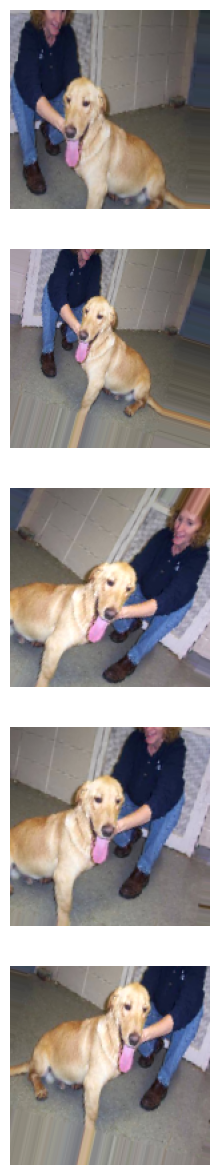

In [35]:
# 6
train_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                     directory=train_dir,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     class_mode='binary')

augmented_images = [train_data_gen[0][0][0] for i in range(5)]

plotImages(augmented_images)

In [36]:
# 7


model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    layers.BatchNormalization(),
    layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2, 2),

    layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'),
    layers.BatchNormalization(),
    layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2, 2),

    layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'),
    layers.BatchNormalization(),
    layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2, 2),

    layers.Flatten(),
    layers.Dense(1000, activation='relu', kernel_initializer='he_uniform'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(100, activation='relu', kernel_initializer='he_uniform'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(1, activation='sigmoid')
])

# Compile
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.summary()


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_22 (Conv2D)                   │ (None, 150, 150, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_24               │ (None, 150, 150, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_23 (Conv2D)                   │ (None, 150, 150, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_25               │ (None, 150, 150, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_13 (MaxPooling2D)      │ (None, 75, 75, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_24 (Conv2D)                   │ (None, 75, 75, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_26               │ (None, 75, 75, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_25 (Conv2D)                   │ (None, 75, 75, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_27               │ (None, 75, 75, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_14 (MaxPooling2D)      │ (None, 37, 37, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_26 (Conv2D)                   │ (None, 37, 37, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_28               │ (None, 37, 37, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_27 (Conv2D)                   │ (None, 37, 37, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_29               │ (None, 37, 37, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_15 (MaxPooling2D)      │ (None, 18, 18, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (None, 41472)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 1000)                │      41,473,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_30               │ (None, 1000)                │           4,000 │
│ (BatchNormalization)                 │                             │              

 Total params: 41,866,401 (159.71 MB)

 Trainable params: 41,863,305 (159.70 MB)

 Non-trainable params: 3,096 (12.09 KB)

In [38]:
print("Total test samples:", test_data_gen.samples)

Total test samples: 50


In [41]:
# 8

history = model.fit(
    train_data_gen,
    steps_per_epoch=total_train // (batch_size // 2),
    epochs=10,
    validation_data=val_data_gen,
    validation_steps=total_val // (batch_size // 2)
)


Epoch 1/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 569s 18s/step - accuracy: 0.6163 - loss: 0.7085 - val_accuracy: 0.5030 - val_loss: 2.1599
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 617s 18s/step - accuracy: 0.6450 - loss: 0.6614 - val_accuracy: 0.5020 - val_loss: 1.5794
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 626s 18s/step - accuracy: 0.6667 - loss: 0.6559 - val_accuracy: 0.5260 - val_loss: 0.8783
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 604s 19s/step - accuracy: 0.6879 - loss: 0.5984 - val_accuracy: 0.5010 - val_loss: 2.1346
Epoch 5/10
16/31 ━━━━━━━━━━━━━━━━━━━━ 7:59 32s/step - accuracy: 0.6973 - loss: 0.5910

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


31/31 ━━━━━━━━━━━━━━━━━━━━ 571s 18s/step - accuracy: 0.6981 - loss: 0.5879 - val_accuracy: 0.6410 - val_loss: 0.7189
Epoch 6/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


31/31 ━━━━━━━━━━━━━━━━━━━━ 612s 18s/step - accuracy: 0.7085 - loss: 0.5801 - val_accuracy: 0.5600 - val_loss: 0.9209
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 563s 18s/step - accuracy: 0.7190 - loss: 0.5551 - val_accuracy: 0.5410 - val_loss: 1.2845
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 562s 18s/step - accuracy: 0.7196 - loss: 0.5481 - val_accuracy: 0.6270 - val_loss: 0.8318
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 561s 18s/step - accuracy: 0.7404 - loss: 0.5465 - val_accuracy: 0.6450 - val_loss: 0.6869
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 588s 19s/step - accuracy: 0.7443 - loss: 0.5196 - val_accuracy: 0.5880 - val_loss: 0.7361


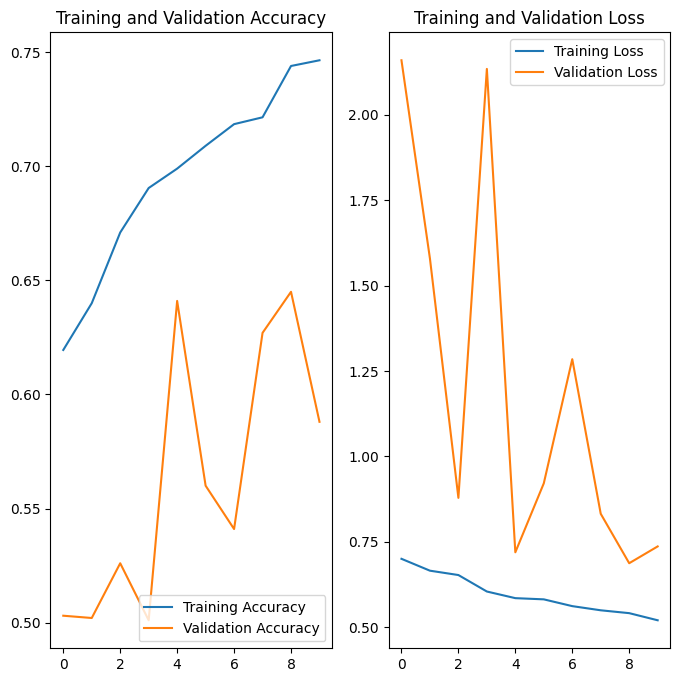

In [42]:
# 9
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

actual_epochs = len(history.history['accuracy'])
epochs_range = range(actual_epochs)


plt.figure(figsize=(8, 8))


plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')


plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()


In [43]:
print("Total test samples:", test_data_gen.samples)  # Should print a number > 0


Total test samples: 50


In [48]:
# 10
probabilities = [int(boolean) for boolean in model.predict(test_data_gen) > 0.5]
print(probabilities)


50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 64ms/step
[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]


<ipython-input-48-9dab861dc813>:2: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  probabilities = [int(boolean) for boolean in model.predict(test_data_gen) > 0.5]


In [51]:
# 11
answers =  [1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0,
            1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0,
            1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1,
            1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1,
            0, 0, 0, 0, 0, 0]

correct = 0

for probability, answer in zip(probabilities, answers):
  if round(probability) == answer:
    correct +=1

percentage_identified = (correct / len(answers)) * 100

passed_challenge = percentage_identified >= 55

print(f"Your model correctly identified {round(percentage_identified, 2)}% of the images of cats and dogs.")

if passed_challenge:
  print("You passed the challenge!")
else:
  print("You haven't passed yet. Your model should identify at least 55% of the images. Keep trying. You will get it!")

Your model correctly identified 56.0% of the images of cats and dogs.
You passed the challenge!
